<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lecture-overview" data-toc-modified-id="Lecture-overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lecture overview</a></span></li><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preliminaries</a></span></li><li><span><a href="#Grouping-your-data:-the-.groupby()-function" data-toc-modified-id="Grouping-your-data:-the-.groupby()-function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grouping your data: the <code>.groupby()</code> function</a></span></li><li><span><a href="#The-.apply()-and-.transform()-methods" data-toc-modified-id="The-.apply()-and-.transform()-methods-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The <code>.apply()</code> and <code>.transform()</code> methods</a></span></li><li><span><a href="#Winsorizing-outliers" data-toc-modified-id="Winsorizing-outliers-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Winsorizing outliers</a></span></li></ul></div>

# Lecture overview

In this lecture we introduce a set of Pandas functions that are very useful in describing subsamples of your data (this is often called "subsample analysis"). Looking at subsamples of your data individually is important because patterns that show up in your overall dataset may look quite different if you limit yourself to a subset of the dataset. This is exemplified in Simpson's Paradox: https://en.wikipedia.org/wiki/Simpson%27s_paradox.

We finish the lecture with a discussion of the impact of outliers on your descriptive statistics, and a method of mitigating that impact called "windsorization".

# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
pd.options.display.max_rows = 20

We'll use data on the Fama-French 5-industry portfolio returns for this lecture:

In [2]:
raw = pdr.DataReader(name = '5_Industry_Portfolios', data_source = 'famafrench', 
                     start = '2011-01-01', end = '2020-12-31')
raw

C:\Users\ionmi\AppData\Local\Temp\ipykernel_16492\1848592197.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw = pdr.DataReader(name = '5_Industry_Portfolios', data_source = 'famafrench',
C:\Users\ionmi\AppData\Local\Temp\ipykernel_16492\1848592197.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw = pdr.DataReader(name = '5_Industry_Portfolios', data_source = 'famafrench',
C:\Users\ionmi\AppData\Local\Temp\ipykernel_16492\1848592197.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw = pdr.DataReader(name = '5_Ind

{0:          Cnsmr  Manuf  HiTec  Hlth   Other
 Date                                      
 2011-01  -1.34   4.30   3.08  -0.72   2.10
 2011-02   2.84   4.85   3.47   3.32   2.94
 2011-03   1.89   1.82  -0.76   2.29  -1.08
 2011-04   4.36   2.58   3.17   6.34   1.06
 2011-05   0.97  -2.57  -1.18   1.95  -2.64
 ...        ...    ...    ...    ...    ...
 2020-08  10.21   3.01   9.93   2.35   6.90
 2020-09  -4.05  -2.37  -4.87  -1.46  -2.93
 2020-10  -2.73   0.02  -2.09  -4.40  -1.58
 2020-11  11.47  12.94  11.18   9.86  15.87
 2020-12   4.01   2.62   5.15   4.70   5.54
 
 [120 rows x 5 columns],
 1:          Cnsmr  Manuf  HiTec  Hlth   Other
 Date                                      
 2011-01  -0.54   3.66   3.18   1.26   1.88
 2011-02   4.14   5.51   5.49   3.46   2.92
 2011-03   1.15   3.34   0.88   2.77  -0.48
 2011-04   2.32   0.49   1.45   5.02   0.23
 2011-05  -1.00  -3.46  -1.78  -0.18  -2.72
 ...        ...    ...    ...    ...    ...
 2020-08   9.83   3.39   3.83   1.29   5.80

Extract equal-weighted *annual* industry returns, and turn them to decimal (they are in percentage points):

In [10]:
ew = raw[3]/100
ew

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
2011,-0.0668,-0.0594,-0.1344,-0.1095,-0.1044
2012,0.2204,0.0897,0.1064,0.2544,0.2586
2013,0.4396,0.3733,0.5077,0.5615,0.4223
2014,0.0463,-0.0846,0.0241,0.1420,0.0806
2015,-0.0948,-0.2243,-0.0348,0.0235,-0.0308
2016,0.1603,0.3362,0.1735,-0.1121,0.3089
2017,0.0651,0.1037,0.2593,0.2549,0.1446
2018,-0.1425,-0.2204,-0.0661,-0.2248,-0.1364
2019,0.1747,0.1204,0.2765,0.2596,0.2637


Let's take a look at the data:

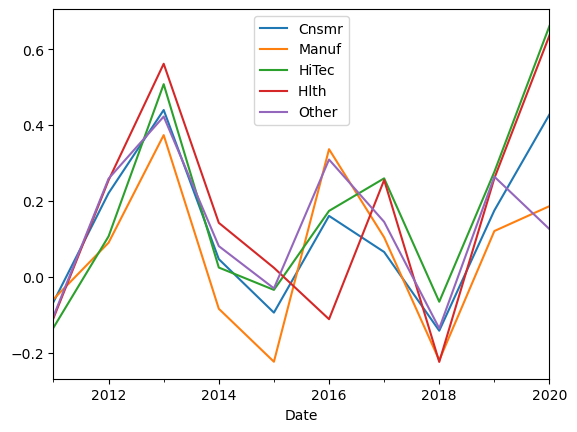

In [6]:
ew.plot();

Calculate cumulative products of gross returns (i.e. compound returns over time) and plot them:

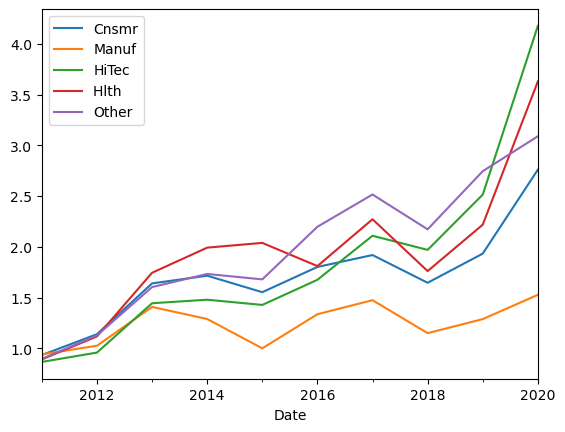

In [12]:
(1+ew).cumprod().plot();

Stack industry returns on top of each other for the purpose of this class:

In [14]:
ew_long = ew.stack().to_frame(name='ewret')
ew_long

ewret
Date              
2011 Cnsmr -0.0668
     Manuf -0.0594
     HiTec -0.1344
     Hlth  -0.1095
     Other -0.1044
...            ...
2020 Cnsmr  0.4278
     Manuf  0.1860
     HiTec  0.6613
     Hlth   0.6363
     Other  0.1254

[50 rows x 1 columns]

And bring date and industry names as data inside the dataframe:

In [19]:
ew_long = ew_long.reset_index().rename(columns = {'level_1': 'Industry'})
ew_long

,Date,Industry,ewret
0,2011,Cnsmr,-0.0668
1,2011,Manuf,-0.0594
2,2011,HiTec,-0.1344
3,2011,Hlth,-0.1095
4,2011,Other,-0.1044
...,...,...,...
45,2020,Cnsmr,0.4278
46,2020,Manuf,0.1860
47,2020,HiTec,0.6613
48,2020,Hlth,0.6363


**Challenge:**

Do the same for value-weighted annual returns (i.e. create a "vw_long" dataframe, using the same steps we used for "ew_long":

In [20]:
vw = raw[2]/100
vw

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
2011,0.0894,0.0445,0.0044,0.1069,-0.1106
2012,0.1623,0.0870,0.1701,0.2041,0.2291
2013,0.3309,0.2927,0.3318,0.4161,0.4127
2014,0.1271,0.0328,0.1447,0.2477,0.1141
2015,0.0710,-0.1193,0.0376,0.0575,-0.0047
2016,0.0547,0.2089,0.1409,-0.0207,0.2002
2017,0.1882,0.1771,0.2933,0.2234,0.2146
2018,-0.0355,-0.1127,-0.0050,0.0469,-0.1012
2019,0.2588,0.2103,0.4210,0.2028,0.3065


In [21]:
vw_long = vw.stack().to_frame(name='vwret')\
            .reset_index().rename(columns = {'level_1':'Industry'})
vw_long

,Date,Industry,vwret
0,2011,Cnsmr,0.0894
1,2011,Manuf,0.0445
2,2011,HiTec,0.0044
3,2011,Hlth,0.1069
4,2011,Other,-0.1106
...,...,...,...
45,2020,Cnsmr,0.3795
46,2020,Manuf,-0.0007
47,2020,HiTec,0.4180
48,2020,Hlth,0.1871


Merge the EW returns and VW returns into a single dataframe called "ireturns":

In [22]:
ireturns = ew_long.merge(vw_long, how='inner', on = ['Date','Industry'])
ireturns

,Date,Industry,ewret,vwret
0,2011,Cnsmr,-0.0668,0.0894
1,2011,Manuf,-0.0594,0.0445
2,2011,HiTec,-0.1344,0.0044
3,2011,Hlth,-0.1095,0.1069
4,2011,Other,-0.1044,-0.1106
...,...,...,...,...
45,2020,Cnsmr,0.4278,0.3795
46,2020,Manuf,0.1860,-0.0007
47,2020,HiTec,0.6613,0.4180
48,2020,Hlth,0.6363,0.1871


# Grouping your data: the ``.groupby()`` function

The ``.groupby()`` function can be used to tell Python that you want to split your data into groups. The parameters of the ``.groupby()`` function tell Python *how* those groups should be created. The purpose is usually to apply some function (e.g. the ".mean()" function) to each of these groups separately.

Abbreviated syntax:
```python
DataFrame.groupby(by=None, axis=0, level=None, as_index=True, sort=True, dropna=True)
```

The most important parameter is ``by``. This is where you tell Python which column (or index) in your DataFrame contains the information based on which you want to group your data. Python will split your DataFrame into "mini" dataframes, one for each unique value of the variable(s) you supplied to the ``by`` parameter.

For example, the line below splits ``ireturns`` into 5 different dataframes, one for each unique entry found in the "Industry" column, and then applies the ``.mean()`` function for each of these 5 dataframes separately. Finally, these subsample means are all collected into a new dataframe ``ind_means``: 

In [23]:
ind_means = ireturns.groupby(by = 'Industry').mean()
ind_means

,Date,ewret,vwret
Industry,,,
Cnsmr,2015,0.12301,0.16264
HiTec,2015,0.17735,0.19568
Hlth,2015,0.16858,0.16718
Manuf,2015,0.06206,0.08206
Other,2015,0.13325,0.13327


If you don't want the ``by`` variable (i.e. "Industry" in the example above) to be the index of the resulting dataframe:

In [24]:
ind_means = ireturns.groupby(by='Industry', as_index=False).mean()
ind_means

,Industry,Date,ewret,vwret
0,Cnsmr,2015,0.12301,0.16264
1,HiTec,2015,0.17735,0.19568
2,Hlth,2015,0.16858,0.16718
3,Manuf,2015,0.06206,0.08206
4,Other,2015,0.13325,0.13327


Another example, with a different ``by`` variable and a different function applied to each group (i.e. median instead of mean):

In [26]:
an_means = ireturns.groupby(by='Date')[['ewret','vwret']].median()
an_means

,ewret,vwret
Date,,
2011,-0.1044,0.0445
2012,0.2204,0.1701
2013,0.4396,0.3318
2014,0.0463,0.1271
2015,-0.0348,0.0376
2016,0.1735,0.1409
2017,0.1446,0.2146
2018,-0.1425,-0.0355
2019,0.2596,0.2588


You can group by more than one variable:

In [27]:
twodim = ireturns.groupby(by = ['Date','Industry']).mean()
twodim

ewret   vwret
Date Industry                
2011 Cnsmr    -0.0668  0.0894
     HiTec    -0.1344  0.0044
     Hlth     -0.1095  0.1069
     Manuf    -0.0594  0.0445
     Other    -0.1044 -0.1106
...               ...     ...
2020 Cnsmr     0.4278  0.3795
     HiTec     0.6613  0.4180
     Hlth      0.6363  0.1871
     Manuf     0.1860 -0.0007
     Other     0.1254  0.0720

[50 rows x 2 columns]

The example above did not really change the ``ireturns`` dataframe, since each "Date" x "Industry" pair has a single entry for both "ewret" and "vwret". Since the mean of a single number is the number itself, the ``twodim`` dataframe will be identical to ``ireturns``. Note that this is not necessarily the case if we used a different function instead of ``.mean()``, for example ``.count()``:

In [28]:
twodim = ireturns.groupby(by = ['Date','Industry']).count()
twodim

ewret  vwret
Date Industry              
2011 Cnsmr         1      1
     HiTec         1      1
     Hlth          1      1
     Manuf         1      1
     Other         1      1
...              ...    ...
2020 Cnsmr         1      1
     HiTec         1      1
     Hlth          1      1
     Manuf         1      1
     Other         1      1

[50 rows x 2 columns]

You can specify which variable(s) you want to apply the function to, in brackets, right before the function name (if you leave this out (like above), the function will be applied to all the columns in the dataframe):

In [30]:
ind_ew_medians = ireturns.groupby('Industry')['ewret'].median()
ind_ew_medians

Industry
Cnsmr    0.11270
HiTec    0.13995
Hlth     0.19820
Manuf    0.09670
Other    0.13500
Name: ewret, dtype: float64

# The ``.apply()`` and ``.transform()`` methods

The ``.apply()`` and ``.transform()``  methods do similar things: they can be used to tell Python to apply a given function to some data from a dataframe. As the examples above show, there are many Pandas functions, like ``.mean()`` and ``.median()`` that can do this without the help of ``.apply()`` or ``.transform()`` (we just have to add the names of these functions after the ``.groupby()`` statement, just like we did above). But what if the function we want to apply is not a built-in Pandas function that can be applied with a dot after the name of a dataframe? This is where ``.apply()`` and ``.transform()`` come in handy. These methods are especially useful when we want to apply a particular function, separately, to each group we created with a ``.groupby`` statement. 

Here is their syntax:

Syntax for ``.transform()``:
```python
DataFrame.transform(func, axis=0, *args, **kwargs)
```
Syntax for ``.apply()``:
```python
DataFrame.apply(func, axis=0, raw=False, result_type=None, args=(), **kwargs)
```

The most important argument is ``func`` which is where we tell Python which function we want to apply to the data. 

The main difference between ``.transform()`` and ``.apply()`` is that ``.transform()`` returns a sequence of the same length as the dataframe to which it is applied, while ``.apply()`` returns a DataFrame or Series of the same size as the number of groups to which it is applied.

In [31]:
ireturns.groupby('Industry')['ewret'].apply(func = np.median)

Industry
Cnsmr    0.11270
HiTec    0.13995
Hlth     0.19820
Manuf    0.09670
Other    0.13500
Name: ewret, dtype: float64

In [32]:
ireturns.groupby('Industry')['ewret'].transform(func = np.median)

0     0.11270
1     0.09670
2     0.13995
3     0.19820
4     0.13500
       ...   
45    0.11270
46    0.09670
47    0.13995
48    0.19820
49    0.13500
Name: ewret, Length: 50, dtype: float64

We usually add the results of ``.transform()`` as a new column to the same dataframe:

In [34]:
mycopy = ireturns.copy()
mycopy['ind_means'] = mycopy.groupby('Industry')['ewret'].transform(np.median)
mycopy.head(10)

,Date,Industry,ewret,vwret,ind_means
0,2011,Cnsmr,-0.0668,0.0894,0.11270
1,2011,Manuf,-0.0594,0.0445,0.09670
2,2011,HiTec,-0.1344,0.0044,0.13995
3,2011,Hlth,-0.1095,0.1069,0.19820
4,2011,Other,-0.1044,-0.1106,0.13500
5,2012,Cnsmr,0.2204,0.1623,0.11270
6,2012,Manuf,0.0897,0.0870,0.09670
7,2012,HiTec,0.1064,0.1701,0.13995
8,2012,Hlth,0.2544,0.2041,0.19820
9,2012,Other,0.2586,0.2291,0.13500


Note, also, that with ``.transform()``, you can pass the name of the function you want as a **string** to the ``func`` argument, whereas with ``.apply()`` you can not:

In [35]:
ireturns.groupby('Industry')[['ewret','vwret']].transform('median')

,ewret,vwret
0,0.11270,0.14470
1,0.09670,0.06575
2,0.13995,0.15740
3,0.19820,0.19495
4,0.13500,0.15715
...,...,...
45,0.11270,0.14470
46,0.09670,0.06575
47,0.13995,0.15740
48,0.19820,0.19495


Whereas the line below will not work. You have to specify which package the "median" function belongs to (which is why we used ``.apply(np.median)`` above):

In [36]:
ireturns.groupby('Industry')[['ewret','vwret']].apply('median') #this gives an error

,ewret,vwret
Industry,,
Cnsmr,0.11270,0.14470
HiTec,0.13995,0.15740
Hlth,0.19820,0.19495
Manuf,0.09670,0.06575
Other,0.13500,0.15715


We are not restricted to applying functions that come with a package that we have installed. We can also use a function that we created ourselves.

For example, below, we create a function that can take in a Series or a DataFrame of returns, and compounds them:

In [37]:
def compound_returns(x):
    return (1+x).prod() - 1

Now we can apply that function to the returns of each industry:

In [41]:
ireturns.groupby('Industry')[['ewret','vwret']].apply(compound_returns)

,ewret,vwret
Industry,,
Cnsmr,1.759998,3.269747
HiTec,3.177203,4.499593
Hlth,2.629514,3.459905
Manuf,0.526983,1.038652
Other,2.089549,2.142437


Let's see if it worked:

In [42]:
(1+ew).cumprod() - 1

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
2011,-0.066800,-0.059400,-0.134400,-0.109500,-0.104400
2012,0.138877,0.024972,-0.042300,0.117043,0.127202
2013,0.639528,0.407594,0.443924,0.744263,0.603220
2014,0.715438,0.288511,0.478723,0.991948,0.732439
2015,0.552814,-0.000502,0.427263,1.038759,0.679080
2016,0.801730,0.335530,0.674893,0.810214,1.197748
2017,0.919023,0.474024,1.109193,1.271638,1.515542
2018,0.645562,0.149149,0.969775,0.760974,1.172422
2019,0.933042,0.287507,1.514418,1.218122,1.745290


# Winsorizing outliers 

"Winsorizing" a variable means replacing its most extreme values with less extreme values. For example, winsorizing a variable "at the 5 and 95 percentiles", means that the values of that variable that are smaller than the 5th percentile will be made equal to the 5th percentile and the values that are larger than the 95th percentile will be made equal to the 95th percentile.

You can pick other values for the percentiles at which you want to winsorize but (1,99) and (5, 95) are by far the most common ones.

To winsorize a variable, in a Pandas dataframe, we use the ``.clip()`` function as below. This also requires us to use the ``.quantile()`` function to calculate the 5th and 95th percentiles. First, let's sort the returns so we can easily see its most extreme values (top and bottom):

In [44]:
ew_long.sort_values('ewret')

,Date,Industry,ewret
38,2018,Hlth,-0.2248
21,2015,Manuf,-0.2243
36,2018,Manuf,-0.2204
35,2018,Cnsmr,-0.1425
39,2018,Other,-0.1364
...,...,...,...
10,2013,Cnsmr,0.4396
12,2013,HiTec,0.5077
13,2013,Hlth,0.5615
48,2020,Hlth,0.6363


Let's calculate the 5th and 95th percentiles:

In [45]:
q5 = ew_long['ewret'].quantile(0.05)
q5

-0.18534499999999998

In [46]:
q95 = ew_long['ewret'].quantile(0.95)
q95

0.5372899999999998

And now let's create a version of ``ewret`` that is winsorized at the 5 and 95 percentiles:

In [47]:
ew_long['ew_wins'] = ew_long['ewret'].clip(lower=q5, upper=q95)

Let's see if it worked:

In [48]:
ew_long.sort_values('ewret')

,Date,Industry,ewret,ew_wins
38,2018,Hlth,-0.2248,-0.185345
21,2015,Manuf,-0.2243,-0.185345
36,2018,Manuf,-0.2204,-0.185345
35,2018,Cnsmr,-0.1425,-0.142500
39,2018,Other,-0.1364,-0.136400
...,...,...,...,...
10,2013,Cnsmr,0.4396,0.439600
12,2013,HiTec,0.5077,0.507700
13,2013,Hlth,0.5615,0.537290
48,2020,Hlth,0.6363,0.537290
